## MNIST classifier

Build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set

#### Load dependencies

In [21]:
# This will help us to measure the time it took for the whole
# notebook to execute
import time
start_time = time.time()

import numpy as np
import importlib
import sys
sys.path.append('../../utils')
import datasets
importlib.reload(datasets)
import helpers
importlib.reload(helpers)

# Allows plot inside jupyer notebooks
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn
from sklearn.datasets import fetch_openml           # Fetches data using openML
from sklearn.model_selection import GridSearchCV    # Performs a grid search to find the optimal hyperparameters for a given model.
from sklearn.neighbors import KNeighborsClassifier  # Used in supervised learning tasks. After fitting the model to a training dataset, it can be used to predict the class labels for new instances.
from sklearn.metrics import accuracy_score          # Function that calculates the accuracy of predictions

import scipy
# Used to shift an array along specified dimensions. 
# It's commonly used to apply transformations, like small translations, 
# to images or multi-dimensional data, which is especially useful in data augmentation.
from scipy.ndimage import shift       

# to make this notebook's output stable across runs
np.random.seed(42)

#### Get dataset

There are 70,000 images, and each image has 784 features.

This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

In [22]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [23]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [24]:
y.shape

(70000,)

#### Preview

Preview a single digit of the dataset

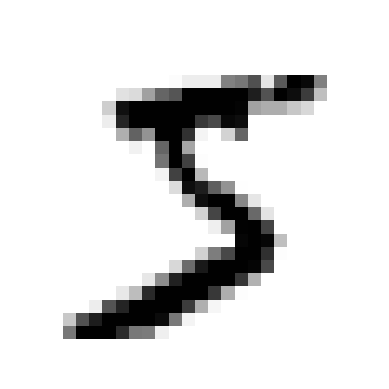

In [25]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [26]:
y[0]

'5'

#### Test dataset

In [27]:
X_train = X[:60000] # Take the first 60000 examples of X
X_test = X[60000:]  # Takes the samples from index 60000 onwards of X
y_train = y[:60000] # Take the first 60000 examples of y
y_test = y[60000:]  # Takes the samples from index 60000 onwards of y

#### Classifier

Here, param_grid is a dictionary specifying the hyperparameters to be tested for the K-Nearest Neighbors (KNN) classifier.
- 'weights': ["uniform", "distance"] tells GridSearchCV to try two different weighting methods:
    - "uniform": All points in each neighborhood contribute equally.
    - "distance": Closer neighbors contribute more weight in the prediction.
- 'n_neighbors': [3, 4, 5] tells GridSearchCV to test KNN with 3, 4, and 5 neighbors.

In [28]:
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

##### Creating the Classifier and Setting up the Grid Search

- **knn_clf = KNeighborsClassifier()** creates an instance of the KNN classifier.
- **grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)** initializes the grid search:
    - **knn_clf** is passed as the base classifier for which we want to tune the parameters.
    - **param_grid** defines the hyperparameter combinations to test.
    - **cv=5** specifies 5-fold cross-validation. 
      This means the dataset will be split into 5 parts, with the model being trained on 4 parts and validated on the 5th part, iteratively. This improves the reliability of the results by ensuring that each part of the dataset gets used for validation once.
    - **verbose=3** controls the level of output details. A higher verbose level prints more details about the progress of the grid search, which can be useful for tracking.

- **grid_search.fit(X_train, y_train)** starts the grid search on the training data (X_train and y_train).
- The grid search will try each combination of parameters from param_grid, train the model with these parameters, and evaluate it using cross-validation.
- For each parameter combination, the mean cross-validation score (default is accuracy for classification) is calculated. After all combinations are tested, **GridSearchCV** selects the parameters that produced the best score.

In [29]:
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=   8.6s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=   8.4s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=   8.4s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=   8.1s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=   7.8s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=   7.6s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=   7.7s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=   7.8s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=   7.6s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=   7.8s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=  11.1s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [30]:
# Show the best combination of parameters found
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [31]:
# Provides the cross-validation score of the model with those parameters.
grid_search.best_score_

np.float64(0.9716166666666666)

##### Making Predictions on the Test Set

- **grid_search.predict(X_test)** uses the model trained and tuned by **GridSearchCV** to make predictions on the test set **X_test**.
- This method automatically uses the best-found parameters (stored in **grid_search.best_estimator_**), ensuring predictions are made with the optimized model.
- The predictions are stored in **y_pred**, a vector of predicted labels.

In [32]:
y_pred = grid_search.predict(X_test)

##### Calculating the accuracy

- **accuracy_score(y_test, y_pred)** compares the actual labels (**y_test**) with the predicted labels (**y_pred**) and calculates the accuracy.
- Accuracy is defined as:
$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
$$
- This value ranges from 0 to 1, where 1 means perfect accuracy.

The result gives you a straightforward performance metric indicating how well your tuned KNN model performs on the test set. 

It’s a quick way to understand the model’s effectiveness in classifying new, unseen data after hyperparameter tuning.

In [33]:
accuracy_score(y_test, y_pred)

0.9714

## Data augmentation

Applying data augmentation technique to get a better accuracy.

In [34]:
# Function to shift images

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

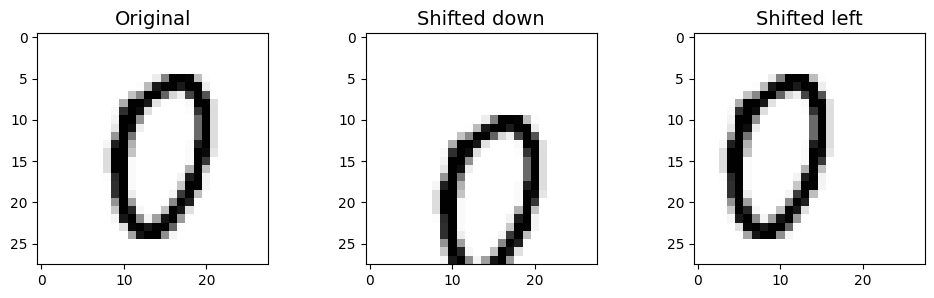

In [35]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [36]:
# Copying training data
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

# Shifting images and appending them
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

# Converting into numpy arrays for numerical operationsm which is used in many ML libraries
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [37]:
# Creates a random permutation of indices based on the length of X_train_augmented
shuffle_idx = np.random.permutation(len(X_train_augmented))

# Shuffles the data
# This helps ensure that the model does not learn any unintended 
# patterns from the order of the training data.
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [38]:
# Initializing a KNN classifier
# usgin the best combination of hyperparameters that were identified during the search process
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

# fit method trains the classifier with the augmented data
# KNN algorithm learns from the provided training data, essentially memorizing the training examples
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

##### Making predictions

`y_pred = knn_clf.predict(X_test)`

- The **predict** method is called on the trained **knn_clf** classifier with **X_test** as the input. 
- **X_test** is expected to be the test dataset containing features (images or other data points) that the model has not seen before.
- This method uses the KNN algorithm to predict the labels for each instance in **X_test**. The predicted labels are stored in the **y_pred** variable.

`accuracy_score(y_test, y_pred)`
- **accuracy_score** is a function from **scikit-learn** that computes the accuracy of the predictions. 
- It takes two arguments: the true labels (**y_test**) and the predicted labels (**y_pred**).
- Accuracy is calculated as the ratio of the number of correct predictions to the total number of predictions made.
- It is typically expressed as a percentage. A higher accuracy indicates a better-performing model.
- The function returns a float value representing the accuracy score, which can be further used for evaluation or reporting.

In [39]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

After data was augmented, we see an increase of 0.5% in accuracy.

---

## Total Time

This show the total time of execution

In [40]:
# Sets the total time of execution
end_time = time.time()
helpers.calculate_execution_time(start_time, end_time)

Total execution time: 7.0 minutes and 10.26 seconds
